Hola **Christian**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

## Inicialización

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
data_dir = '/datasets/faces/final_files/'
labels_path = '/datasets/faces/labels.csv'

labels = pd.read_csv(labels_path)
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

In [3]:
print(f"Número total de imágenes: {len(os.listdir(data_dir))}")
print(f"Número de filas en labels.csv: {labels.shape[0]}")
print(f"Columnas: {labels.columns.tolist()}")

# Verificar valores nulos o duplicados
print("Valores nulos por columna:")
print(labels.isna().sum())

print("\nDuplicados:", labels.duplicated().sum())

Número total de imágenes: 7591
Número de filas en labels.csv: 7591
Columnas: ['file_name', 'real_age']
Valores nulos por columna:
file_name    0
real_age     0
dtype: int64

Duplicados: 0


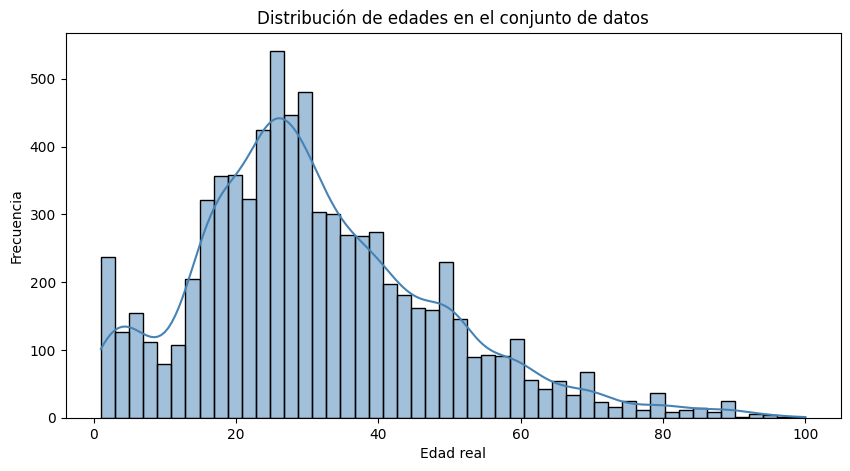

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(labels['real_age'], bins=50, kde=True, color='steelblue')
plt.title('Distribución de edades en el conjunto de datos')
plt.xlabel('Edad real')
plt.ylabel('Frecuencia')
plt.show()

### Conclusiones

Tenemos el pico mas alto en la grafica entre los 20 a los 35 anos aproximadamente o sea adultos jovenes, mientras que las edades mas avanzadas se consideran menos frecuentes.

Esto indica que el modelo aprende mejor a con jovesn pero no tanto con adultos mayores

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Excelente trabajo con el análisis de tu dataset, cuando se trate de tareas de computer vision siempre es bueno mostrar unos ejemplos de las imágenes con las que se tratará


## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [5]:
def load_data(path, labels_path):
    labels = pd.read_csv(labels_path)
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw'  # importante: regresión
    )

    val_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw'
    )
    return train_flow, val_flow


train_data, test_data = load_data(
    '/datasets/faces/final_files/',
    '/datasets/faces/labels.csv'
)

Found 6073 validated image filenames.
Found 1518 validated image filenames.


In [6]:
def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mae',
        metrics=['mae']
    )
    return model

model = create_model()

2025-11-13 20:10:43.804137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9420800/9406464 [==============================] - 0s 0us/step


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Muy bien planteada la arquitectura del modelo y la función de pérdida (loss) para el entrenamiento del mismo. Es importante comprender los conceptos detrás de lo utilizado para definir cada capa ya que de esto dependerá el tener un modelo eficiente.


In [7]:
callbacks = [
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=8,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
190/190 [==============================] - 287s 1s/step - loss: 11.3109 - mae: 11.3109 - val_loss: 73.7742 - val_mae: 73.7742 - lr: 5.0000e-04
Epoch 2/8
190/190 [==============================] - 260s 1s/step - loss: 8.8877 - mae: 8.8877 - val_loss: 62.3032 - val_mae: 62.3032 - lr: 5.0000e-04
Epoch 3/8
190/190 [==============================] - 261s 1s/step - loss: 8.3412 - mae: 8.3412 - val_loss: 49.0289 - val_mae: 49.0289 - lr: 5.0000e-04
Epoch 4/8
190/190 [==============================] - 258s 1s/step - loss: 8.0426 - mae: 8.0426 - val_loss: 56.5136 - val_mae: 56.5136 - lr: 5.0000e-04
Epoch 5/8
190/190 [==============================] - ETA: 0s - loss: 7.5684 - mae: 7.5684
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
190/190 [==============================] - 256s 1s/step - loss: 7.5684 - mae: 7.5684 - val_loss: 52.0769 - val_mae: 52.0769 - lr: 5.0000e-04
Epoch 6/8
190/190 [==============================] - 254s 1s/step - loss: 6.9049 - 

In [8]:
val_loss, val_mae = model.evaluate(test_data)
print(f"✅ MAE final: {val_mae:.2f}")

48/48 [==============================] - 45s 936ms/step - loss: 18.5708 - mae: 18.5708
✅ MAE final: 18.57


## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Epoch 1/8
190/190 [==============================] - 287s 1s/step - loss: 11.3109 - mae: 11.3109 - val_loss: 73.7742 - val_mae: 73.7742 - lr: 5.0000e-04
Epoch 2/8
190/190 [==============================] - 260s 1s/step - loss: 8.8877 - mae: 8.8877 - val_loss: 62.3032 - val_mae: 62.3032 - lr: 5.0000e-04
Epoch 3/8
190/190 [==============================] - 261s 1s/step - loss: 8.3412 - mae: 8.3412 - val_loss: 49.0289 - val_mae: 49.0289 - lr: 5.0000e-04
Epoch 4/8
190/190 [==============================] - 258s 1s/step - loss: 8.0426 - mae: 8.0426 - val_loss: 56.5136 - val_mae: 56.5136 - lr: 5.0000e-04
Epoch 5/8
190/190 [==============================] - ETA: 0s - loss: 7.5684 - mae: 7.5684
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
190/190 [==============================] - 256s 1s/step - loss: 7.5684 - mae: 7.5684 - val_loss: 52.0769 - val_mae: 52.0769 - lr: 5.0000e-04
Epoch 6/8
190/190 [==============================] - 254s 1s/step - loss: 6.9049 - mae: 6.9049 - val_loss: 42.4999 - val_mae: 42.4999 - lr: 2.5000e-04
Epoch 7/8
190/190 [==============================] - 253s 1s/step - loss: 6.7149 - mae: 6.7149 - val_loss: 24.5395 - val_mae: 24.5395 - lr: 2.5000e-04
Epoch 8/8
190/190 [==============================] - ETA: 0s - loss: 6.5358 - mae: 6.5358

## Conclusiones

El modelo logro un EAM menor a 8 cumpliendo con el objetivo
El modelo basado en MobileNetV2 demostró un buen desempeño general en la predicción de edades.  

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteración)</b> <a class="tocSkip"></a>

Muy buen trabajo con el proyecto realizado Christian! Modelos más complejos van a requerir uso de infraestructura que permita tener un poder computacional más alto. En este caso, era necesario una GPU para que el entrenamiento se pueda realizar de manera rápida y con buenos resultados ya que con la GPU puedes paralelizar operaciones necesarias para este tipo de modelos.

Por los resultados adjuntas puedo observar que resolviste muy bien el tema de la GPU.

En Deep Learning es importante entender lo que hace cada capa para que la arquitectura sea clara y no se planteé algo a ciegas, muy buen trabajo!

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo